In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
from tqdm import tqdm
from PIL import Image
import io

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import EfficientNetB2
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.vgg16 import VGG16
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D, Average, Input, Concatenate, GlobalMaxPooling2D,BatchNormalization
from keras.applications import ResNet50,MobileNet, DenseNet201, InceptionV3, DenseNet121, DenseNet169, InceptionResNetV2, NASNetMobile
from keras.applications.xception import Xception
from keras.models import Model
from keras.optimizers import Adam
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix
from IPython.display import display, clear_output
import ipywidgets as widgets

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
labels = ['Benign', 'Melanoma']
X_train = []
Y_train  = []
X_test = []
Y_test = []
image_size=224

for label in labels:
    trainPath = os.path.join('/content/drive/MyDrive/ISBI2017/train',label)
    for file in tqdm(os.listdir(trainPath)):
        image = cv2.imread(os.path.join(trainPath, file))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (image_size, image_size))
        X_train.append(image)
        Y_train.append(label)

    testPath = os.path.join('/content/drive/MyDrive/ISBI2017/test',label)
    for file in tqdm(os.listdir(testPath)):
        image = cv2.imread(os.path.join(testPath, file))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (image_size, image_size))
        X_test.append(image)
        Y_test.append(label)

X_train = np.array(X_train)
X_test = np.array(X_test)

100%|██████████| 207/207 [00:09<00:00, 21.64it/s]


In [4]:
X_train, Y_train = shuffle(X_train, Y_train, random_state=1010)
X_test, Y_test = shuffle(X_test, Y_test, random_state=1010)

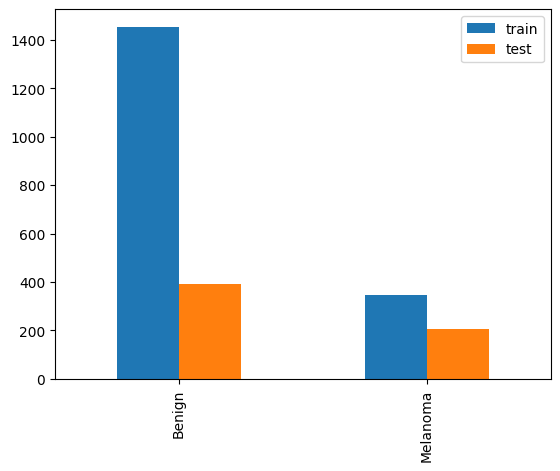

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
_, train_counts = np.unique(Y_train, return_counts=True)
_, test_counts = np.unique(Y_test, return_counts=True)
pd.DataFrame({'train': train_counts,
                    'test': test_counts},
             index=labels
            ).plot.bar()
plt.savefig('dataset',dpi=400)
plt.show()

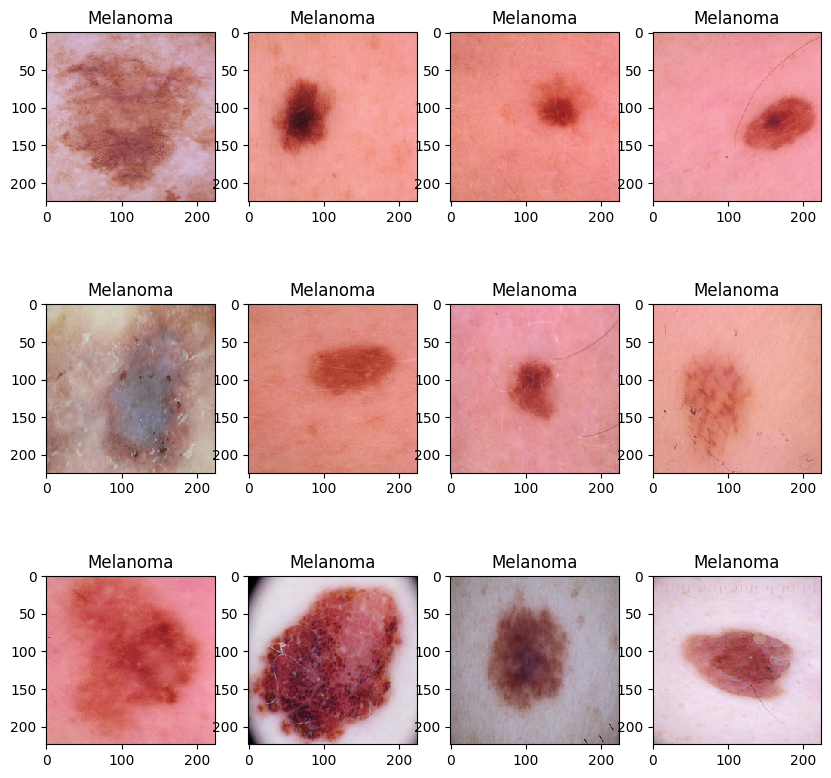

In [ ]:
plt.style.use('default')
w=60
h=40
fig=plt.figure(figsize=(10, 10))
columns = 4
rows = 3

for i in range(1, columns*rows +1):
    ax = fig.add_subplot(rows, columns, i)
    if np.argmax(Y_train[i]) == 1:
        ax.title.set_text('Benign')
    else:
        ax.title.set_text('Melanoma')
    plt.imshow(X_train[i], interpolation='nearest')
plt.savefig('samples',dpi=400)
plt.show()

In [5]:
y_train_ = []
for i in Y_train:
    y_train_.append(labels.index(i))
Y_train = y_train_

Y_train = tf.keras.utils.to_categorical(Y_train)

y_test_ = []
for i in Y_test:
    y_test_.append(labels.index(i))
Y_test = y_test_

Y_test = tf.keras.utils.to_categorical(Y_test)

In [ ]:
X_train = X_train.reshape(900,3*224*224)

In [ ]:
from imblearn.over_sampling import SMOTE
sm_train = SMOTE(random_state=42, sampling_strategy=1)
X_train, Y_train = sm_train.fit_resample(X_train, Y_train)
X_train.shape

(1454, 150528)

In [ ]:
X_train = X_train.reshape(1454,224,224,3)
Y_train = Y_train.reshape(1454,)

In [6]:
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.1, random_state=1010)

In [7]:
BATCH_SIZE = 32

# Using original generator
train_generator = ImageDataGenerator(
        zoom_range=2.5,  # set range for random zoom
        rotation_range = 90,
        shear_range = 0.5,
        width_shift_range=0.5,
        height_shift_range=0.5,
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True  # randomly flip images
    )

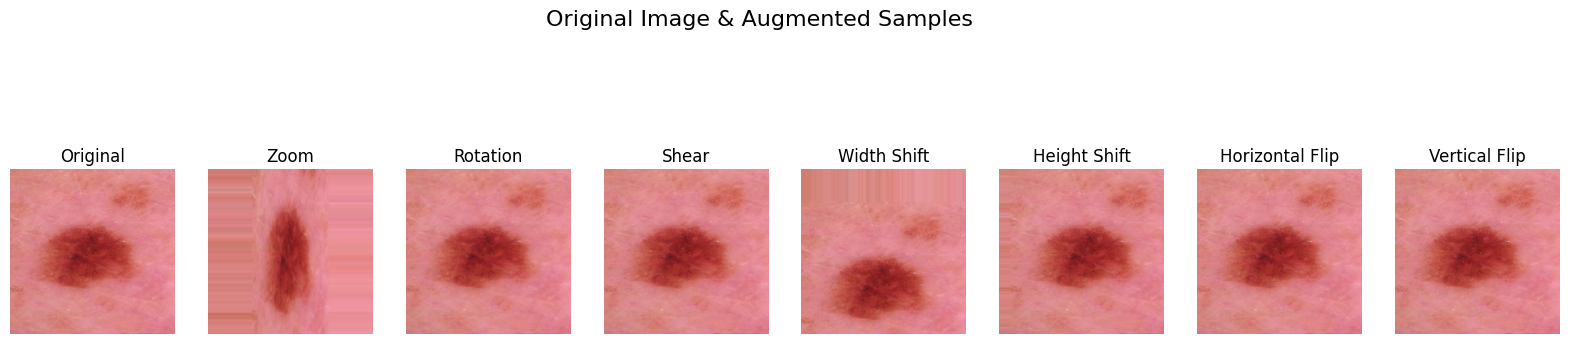

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define augmentation techniques
augmentations = {
    "Original": ImageDataGenerator(),  # No augmentation
    "Zoom": ImageDataGenerator(zoom_range=2.5),
    "Rotation": ImageDataGenerator(rotation_range=90),
    "Shear": ImageDataGenerator(shear_range=0.5),
    "Width Shift": ImageDataGenerator(width_shift_range=0.5),
    "Height Shift": ImageDataGenerator(height_shift_range=0.5),
    "Horizontal Flip": ImageDataGenerator(horizontal_flip=True),
    "Vertical Flip": ImageDataGenerator(vertical_flip=True)
}

# Select a random image from the dataset
img_index = np.random.randint(0, len(X_train))  # Pick a random index
sample_image = X_train[img_index]  # Get the image
sample_image = np.expand_dims(sample_image, axis=0)  # Expand dimensions for augmentation

# Create figure
fig, axes = plt.subplots(1, 8, figsize=(20, 5))
fig.suptitle("Original Image & Augmented Samples", fontsize=16)

# Apply each augmentation and display results
for i, (aug_name, aug_gen) in enumerate(augmentations.items()):
    if aug_name == "Original":
        augmented_image = sample_image  # Keep the original image
    else:
        augmented_image = next(aug_gen.flow(sample_image, batch_size=1))  # Generate augmented image

    # Show image
    axes[i].imshow(augmented_image[0].astype('uint8'))  # Convert image to uint8
    axes[i].axis('off')
    axes[i].set_title(aug_name, fontsize=12)  # Add augmentation name

plt.show()


In [9]:
IMAGE_SIZE=224
# Model
input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3)
inputs = Input(input_shape)

den = DenseNet169(include_top=False, input_shape=input_shape)(inputs)

51877672/51877672 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [10]:
outputs = GlobalAveragePooling2D()(den)
outputs = Dropout(0.4)(outputs)
outputs = BatchNormalization()(outputs)
outputs = Dense(256,activation='relu')(outputs)
outputs = Dense(128,activation='relu')(outputs)
outputs = Dropout(0.2)(outputs)
outputs = Dense(2, activation='softmax')(outputs)

model = Model(inputs, outputs)
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ densenet169 (Functional)             │ (None, 7, 7, 1664)          │      12,642,880 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1664)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1664)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 1664)                │           6,656 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         426,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 13,108,930 (50.01 MB)

 Trainable params: 12,947,202 (49.39 MB)

 Non-trainable params: 161,728 (631.75 KB)

In [11]:
# Learning Rate Reducer
learn_control = ReduceLROnPlateau(monitor='val_acc', patience=5,
                                  verbose=1,factor=0.2, min_lr=1e-7)

# Checkpoint
filepath="/content/drive/MyDrive/SkinDenseNet169_ISBI2017.keras"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')


In [12]:
history = model.fit(
    train_generator.flow(X_train, Y_train, batch_size=BATCH_SIZE),
    steps_per_epoch=X_train.shape[0] // BATCH_SIZE,
    epochs=20,
    validation_data=(X_val, Y_val),
    callbacks=[learn_control, checkpoint]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 581s 6s/step - accuracy: 0.7140 - loss: 0.5280 - val_accuracy: 0.7944 - val_loss: 0.4713 - learning_rate: 1.0000e-04
Epoch 2/20


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/callback_list.py:145: UserWarning: Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: accuracy,loss,val_accuracy,val_loss,learning_rate.
  callback.on_epoch_end(epoch, logs)
/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:209: UserWarning: Can save best model only with val_acc available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)


 1/50 ━━━━━━━━━━━━━━━━━━━━ 23s 475ms/step - accuracy: 0.9688 - loss: 0.0772

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9688 - loss: 0.0772 - val_accuracy: 0.7944 - val_loss: 0.4614 - learning_rate: 1.0000e-04
Epoch 3/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 31s 610ms/step - accuracy: 0.9370 - loss: 0.1701 - val_accuracy: 0.9278 - val_loss: 0.1743 - learning_rate: 1.0000e-04
Epoch 4/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8750 - loss: 0.3314 - val_accuracy: 0.9222 - val_loss: 0.1687 - learning_rate: 1.0000e-04
Epoch 5/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 39s 596ms/step - accuracy: 0.9490 - loss: 0.1250 - val_accuracy: 0.9889 - val_loss: 0.0601 - learning_rate: 1.0000e-04
Epoch 6/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9688 - loss: 0.0740 - val_accuracy: 0.9833 - val_loss: 0.0713 - learning_rate: 1.0000e-04
Epoch 7/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 30s 601ms/step - accuracy: 0.9637 - loss: 0.1033 - val_accuracy: 0.9778 - val_loss: 0.0481 - learning_rate: 1.0000e-04
Epoch 8/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9688 - los

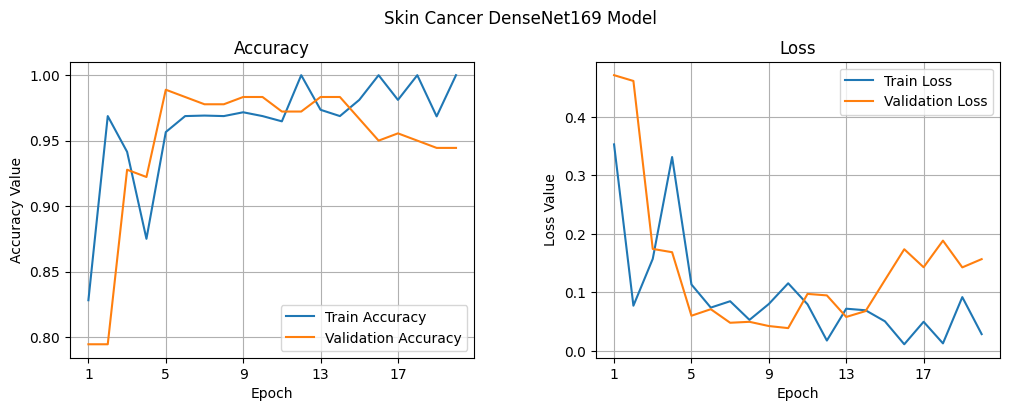

In [13]:
import matplotlib.pyplot as plt
plt.style.use('default')
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('Skin Cancer DenseNet169 Model', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,21))
ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
ax1.grid()
ax1.set_xticks(np.arange(1, 21, 4))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.grid()
ax2.set_xticks(np.arange(1, 21, 4))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")
plt.savefig('curve1',dpi=400)

In [14]:
pred = model.predict(X_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(Y_test,axis=1)
print(classification_report(y_test_new,pred))

19/19 ━━━━━━━━━━━━━━━━━━━━ 58s 2s/step
              precision    recall  f1-score   support

           0       0.96      0.92      0.94       393
           1       0.87      0.93      0.90       207

    accuracy                           0.93       600
   macro avg       0.91      0.93      0.92       600
weighted avg       0.93      0.93      0.93       600



Confusion matrix, without normalization
[[363  30]
 [ 14 193]]


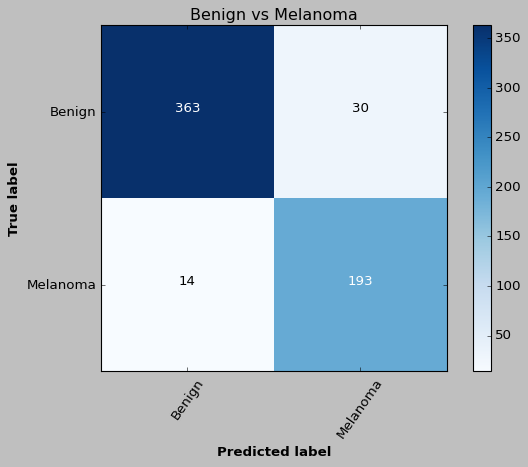

In [15]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
plt.style.use('classic')
import itertools
from itertools import product

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues, fontweight='bold'):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=55)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontweight='bold')
    plt.xlabel('Predicted label', fontweight='bold')
    plt.tight_layout()

cm = confusion_matrix(y_test_new,pred)

cm_plot_label =['Benign', 'Melanoma']
plot_confusion_matrix(cm, cm_plot_label, title ='Benign vs Melanoma')
plt.savefig('CM',dpi=400)

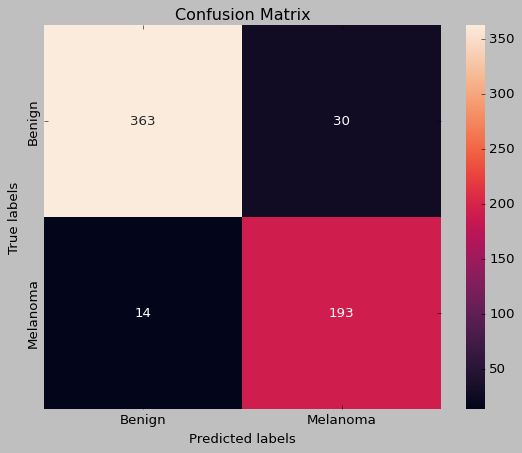

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='d', ax = ax); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(['Benign', 'Melanoma']); ax.yaxis.set_ticklabels(['Benign', 'Melanoma'])
plt.savefig('CM_heatmap',dpi=400)

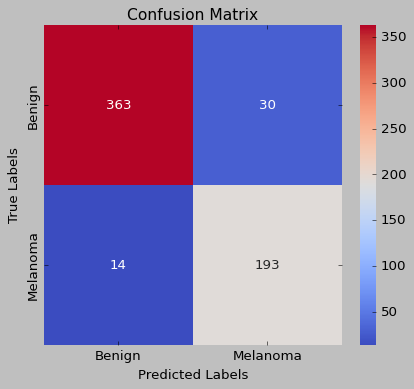

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create the figure and axis
fig, ax = plt.subplots(figsize=(6,5))  # Adjust size if needed

# Plot the heatmap
sns.heatmap(cm, annot=True, fmt='d', cmap='coolwarm', ax=ax)

# Labels, title, and ticks
ax.set_xlabel('Predicted Labels', fontsize=12)
ax.set_ylabel('True Labels', fontsize=12)
ax.set_title('Confusion Matrix', fontsize=14)
ax.xaxis.set_ticklabels(['Benign', 'Melanoma'])
ax.yaxis.set_ticklabels(['Benign', 'Melanoma'])

# Save with better formatting
plt.savefig('CM_heatmap.png', dpi=400, bbox_inches='tight', transparent=True)
plt.show()


In [18]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score,confusion_matrix, roc_curve, auc,roc_auc_score,matthews_corrcoef,cohen_kappa_score

print('Accuracy: %.4f' % accuracy_score(y_test_new, pred), 'Precision: %.4f' % precision_score(y_test_new, pred),' Recall: %.4f' % recall_score(y_test_new, pred),
      'F1 Score: %.4f' % f1_score(y_test_new, pred), 'AUC Score: %.4f' % roc_auc_score(y_test_new, pred),'MCC: %.4f' % matthews_corrcoef(y_test_new, pred),
      'Kappa: %.4f' % cohen_kappa_score(y_test_new, pred))

Accuracy: 0.9267 Precision: 0.8655  Recall: 0.9324 F1 Score: 0.8977 AUC Score: 0.9280 MCC: 0.8421 Kappa: 0.8407


In [19]:
TP=cm[1,1]
TN=cm[0,0]
FP=cm[0,1]
FN=cm[1,0]
print('TP: %f' % TP,'TN: %f' % TN, 'FP: %f' % FP, 'FN: %f' % FN)

TP: 193.000000 TN: 363.000000 FP: 30.000000 FN: 14.000000


In [20]:
specificity=TN/float(TN+FP)
print('Specificity: %.4f' % specificity)
recall=TP/float(TP+FN)
print(' Recall: %.4f' % recall)
precision=TP/float(TP+FP)
print(' Precision: %.4f' % precision)
f1=(2*precision*recall)/(recall+precision)
print('F1 Score: %.4f' % f1)
print( 'AUC Score: %.4f' % roc_auc_score(y_test_new, pred))
from sklearn.metrics import mean_squared_error
print( 'Error Rate: %.5f' % mean_squared_error(y_test_new, pred))
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import cohen_kappa_score

print('MCC: %.4f' % matthews_corrcoef(y_test_new, pred), 'Kappa: %.4f' % cohen_kappa_score(y_test_new, pred))

Specificity: 0.9237
 Recall: 0.9324
 Precision: 0.8655
F1 Score: 0.8977
AUC Score: 0.9280
Error Rate: 0.07333
MCC: 0.8421 Kappa: 0.8407


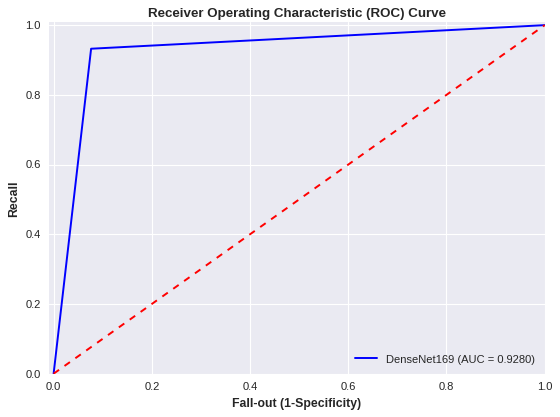

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("seaborn-v0_8")
#Print Area Under Curve
false_positive_rate, recall, thresholds = roc_curve(y_test_new, pred)
roc_auc = auc(false_positive_rate, recall)
plt.figure()
plt.title('Receiver Operating Characteristic (ROC) Curve', fontweight='bold')
plt.plot(false_positive_rate, recall, 'b', label = 'DenseNet169 (AUC = %0.4f)' %roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1], [0,1], 'r--')
plt.xlim([-0.01,1.0])
plt.ylim([0.0,1.01])
plt.ylabel('Recall', fontweight='bold')
plt.xlabel('Fall-out (1-Specificity)', fontweight='bold')
plt.savefig('AUC curve',dpi=400)
plt.show()

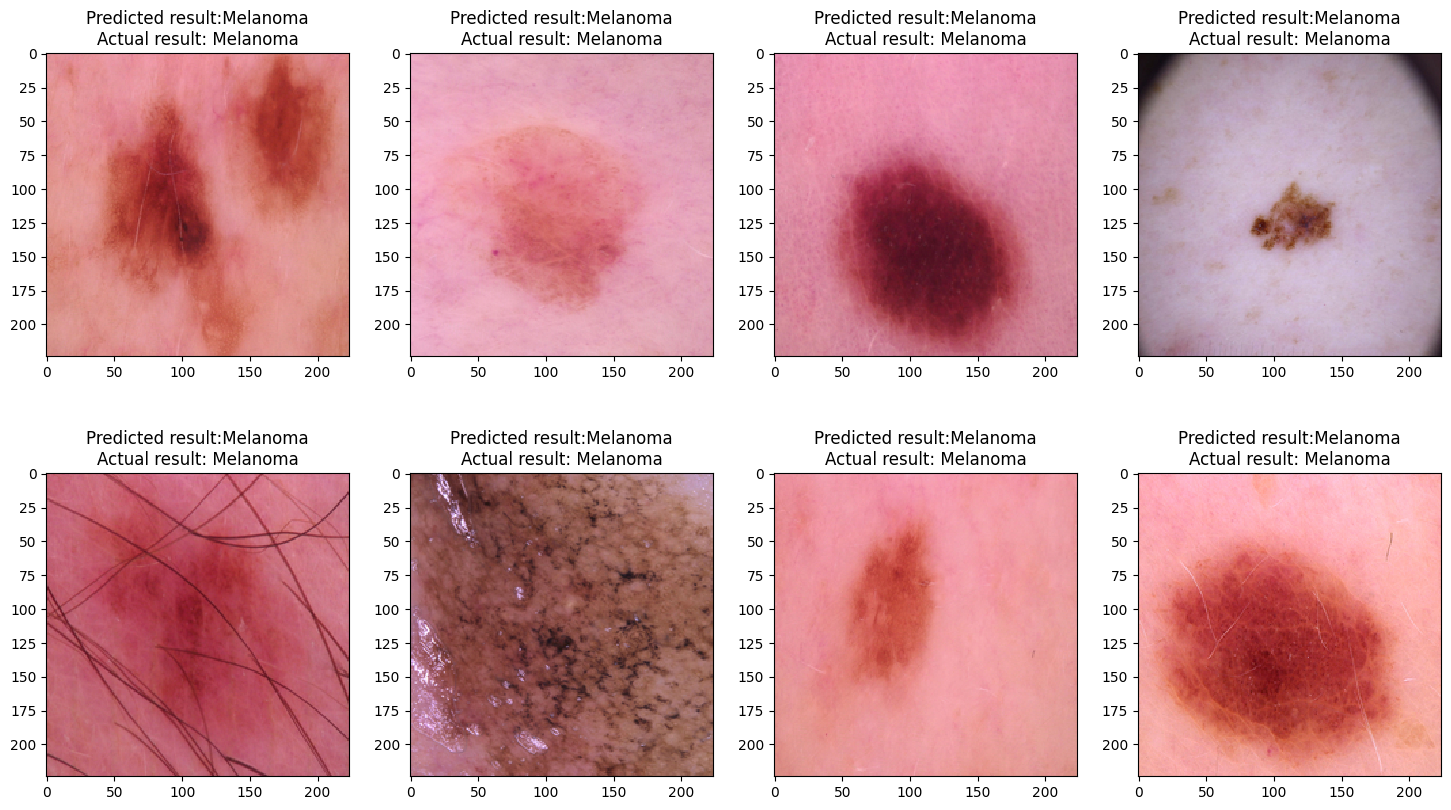

In [ ]:
plt.style.use('default')
i=0
prop_class=[]
mis_class=[]
for i in range(len(Y_test)):
    if(np.argmax(Y_test[i])==np.argmax(pred[i])):
        prop_class.append(i)
    if(len(prop_class)==8):
        break

i=0
for i in range(len(Y_test)):
    if(not np.argmax(Y_test[i])==np.argmax(pred[i])):
        mis_class.append(i)
    if(len(mis_class)==8):
        break

w=60
h=40
fig=plt.figure(figsize=(18, 10))
columns = 4
rows = 2

def Transfername(namecode):
    if namecode==1:
        return "Benign"
    else:
        return "Melanoma"

for i in range(len(prop_class)):
    ax = fig.add_subplot(rows, columns, i+1)
    ax.set_title("Predicted result:"+ Transfername(np.argmax(pred[prop_class[i]]))
                       +"\n"+"Actual result: "+ Transfername(np.argmax(Y_test[prop_class[i]])))
    plt.imshow(X_test[prop_class[i]], interpolation='nearest')
plt.savefig('prediction',dpi=400)
plt.show()